<a href="https://colab.research.google.com/github/KangaOnGit/Marginalized-Corrupted-Features-MCF-/blob/main/Marginalized_Corrupted_Features_(MCF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [50]:
# Define the neural network (same model for both cases)
class MCFNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MCFNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# **Dropout**

---



In [53]:
# Function to corrupt features dynamically (e.g., Bernoulli or Gaussian noise)
def corrupt_features(x, corruption_prob):
    mask = torch.bernoulli((1 - corruption_prob) * torch.ones_like(x))  # Binary mask
    return x * mask

In [51]:
# Quadratic loss for corrupted data
def quadratic_loss(model, inputs, targets, corruption_prob, criterion):
    # Corrupt the features dynamically with the given corruption probability
    corrupted_inputs = corrupt_features(inputs, corruption_prob)

    # Forward pass on the corrupted inputs
    outputs_corrupted = model(corrupted_inputs)

    # Compute the loss (using quadratic loss, assuming it's based on corrupted data)
    loss = criterion(outputs_corrupted, targets)

    return loss, outputs_corrupted  # Return both loss and outputs for accuracy calculation

# MSE loss for uncorrupted data
def mse_loss(model, inputs, targets, criterion):
    # Forward pass on the uncorrupted inputs
    outputs = model(inputs)

    # Compute MSE loss
    loss = criterion(outputs, targets)

    return loss

In [52]:

# Train the model with MCF (quadratic loss on corrupted data)
def train_model_with_mcf(model, train_loader, test_loader, criterion, optimizer, corruption_prob, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            # Compute the loss using corrupted data (quadratic loss)
            loss, outputs_corrupted = quadratic_loss(model, inputs, targets, corruption_prob, criterion)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs_corrupted > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

        # Training accuracy
        train_accuracy = total_correct / total_samples * 100
        print(f"Training Loss: {total_loss/len(train_loader):.4f} | Training Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model
        evaluate_model(model, test_loader, criterion)

In [ ]:
# Train the model with MSE Loss on uncorrupted data
def train_model_with_mse(model, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            # Compute the loss using uncorrupted data (MSE loss)
            loss = mse_loss(model, inputs, targets, criterion)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Compute the outputs for accuracy calculation
            outputs = model(inputs)

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

        # Training accuracy
        train_accuracy = total_correct / total_samples * 100
        print(f"Training Loss: {total_loss/len(train_loader):.4f} | Training Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model
        evaluate_model(model, test_loader, criterion)

In [54]:
# Evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples * 100
    print(f"Evaluation Loss: {total_loss/len(data_loader):.4f} | Evaluation Accuracy: {accuracy:.2f}%")

In [66]:
# Main script
if __name__ == "__main__":
    # Dataset parameters
    num_features = 10
    corruption_prob = 0.2
    batch_size = 32
    epochs = 10
    learning_rate = 0.01

    # Generate datasets
    def generate_fake_dataset(num_samples, num_features, random_seed=42):
        torch.manual_seed(random_seed)
        data = torch.randn(num_samples, num_features)
        labels = torch.sum(data, dim=1, keepdim=True) + torch.randn(num_samples, 1)  # Add noise
        return data, labels

    # Generate the fake dataset
    train_features, train_labels = generate_fake_dataset(90000, num_features)
    test_features, test_labels = generate_fake_dataset(20000, num_features)
    eval_features, eval_labels = generate_fake_dataset(10000, num_features)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_features, test_labels), batch_size=batch_size, shuffle=False)
    eval_loader = DataLoader(TensorDataset(eval_features, eval_labels), batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = MCFNet(input_dim=num_features, hidden_dim=20, output_dim=1)
    criterion = nn.MSELoss()  # MSE loss for training on uncorrupted data
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save the dataset to a file (for later use)
    torch.save({
        'train_features': train_features,
        'train_labels': train_labels,
        'test_features': test_features,
        'test_labels': test_labels,
        'eval_features': eval_features,
        'eval_labels': eval_labels
    }, 'fake_dataset.pth')
    print("Dataset saved to 'fake_dataset.pth'")

    # Step 1: Train the model with MCF (using corrupted data and Quadratic Loss)
    print("Training with MCF (Quadratic Loss on corrupted data):")
    train_model_with_mcf(model, train_loader, eval_loader, criterion, optimizer, corruption_prob, epochs)

    # Reinitialize the model for training without MCF (using original, uncorrupted data)
    model = MCFNet(input_dim=num_features, hidden_dim=20, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Step 2: Train the model with MSE Loss on uncorrupted data
    print("\nTraining without MCF (using MSE on original data):")
    train_model_with_mse(model, train_loader, test_loader, criterion, optimizer, epochs)

Dataset saved to 'fake_dataset.pth'
Training with MCF (Quadratic Loss on corrupted data):
Training Loss: 3.0952 | Training Accuracy: 82.79%
Evaluation Loss: 1.0366 | Evaluation Accuracy: 90.07%
Training Loss: 3.0430 | Training Accuracy: 82.79%
Evaluation Loss: 1.0620 | Evaluation Accuracy: 89.98%
Training Loss: 3.0345 | Training Accuracy: 83.05%
Evaluation Loss: 1.0485 | Evaluation Accuracy: 90.06%
Training Loss: 2.9981 | Training Accuracy: 82.90%
Evaluation Loss: 1.0193 | Evaluation Accuracy: 90.10%
Training Loss: 3.0050 | Training Accuracy: 83.13%
Evaluation Loss: 1.0212 | Evaluation Accuracy: 89.94%
Training Loss: 3.0202 | Training Accuracy: 83.03%
Evaluation Loss: 1.0407 | Evaluation Accuracy: 90.07%
Training Loss: 3.0237 | Training Accuracy: 82.88%
Evaluation Loss: 1.0200 | Evaluation Accuracy: 90.11%
Training Loss: 3.0286 | Training Accuracy: 82.68%
Evaluation Loss: 1.0012 | Evaluation Accuracy: 90.24%
Training Loss: 3.0032 | Training Accuracy: 82.87%
Evaluation Loss: 1.0174 | Ev

Training without MCF (using MSE on original data):

Training Loss: 1.0089 | Training Accuracy: 90.29%
Evaluation Loss: 1.0352 | Evaluation Accuracy: 90.11%

Training with MCF (Quadratic Loss on corrupted data):

0.1:
Training Loss: 2.0220 | Training Accuracy: 86.32%
Evaluation Loss: 1.0086 | Evaluation Accuracy: 90.14%

0.2:
Training Loss: 3.0127 | Training Accuracy: 82.89%
Evaluation Loss: 1.0157 | Evaluation Accuracy: 90.33%

0.3:
Training Loss: 4.0091 | Training Accuracy: 79.84%
Evaluation Loss: 1.0235 | Evaluation Accuracy: 90.23%

0.4:
Training Loss: 4.9888 | Training Accuracy: 76.81%
Evaluation Loss: 1.0227 | Evaluation Accuracy: 90.16%

0.5:
Training Loss: 5.9871 | Training Accuracy: 73.93%
Evaluation Loss: 1.0350 | Evaluation Accuracy: 90.18%

0.6:
Training Loss: 6.9765 | Training Accuracy: 70.89%
Evaluation Loss: 1.0791 | Evaluation Accuracy: 90.07%

0.7:
Training Loss: 7.9890 | Training Accuracy: 67.65%
Evaluation Loss: 1.0856 | Evaluation Accuracy: 90.16%

0.8:
Training Loss: 8.9571 | Training Accuracy: 64.41%
Evaluation Loss: 1.0978 | Evaluation Accuracy: 90.07%

0.9:
Training Loss: 9.9884 | Training Accuracy: 60.26%
Evaluation Loss: 1.0493 | Evaluation Accuracy: 89.88%

1:
Training Loss: 10.9527 | Training Accuracy: 56.00%
Evaluation Loss: 10.9226 | Evaluation Accuracy: 55.86%

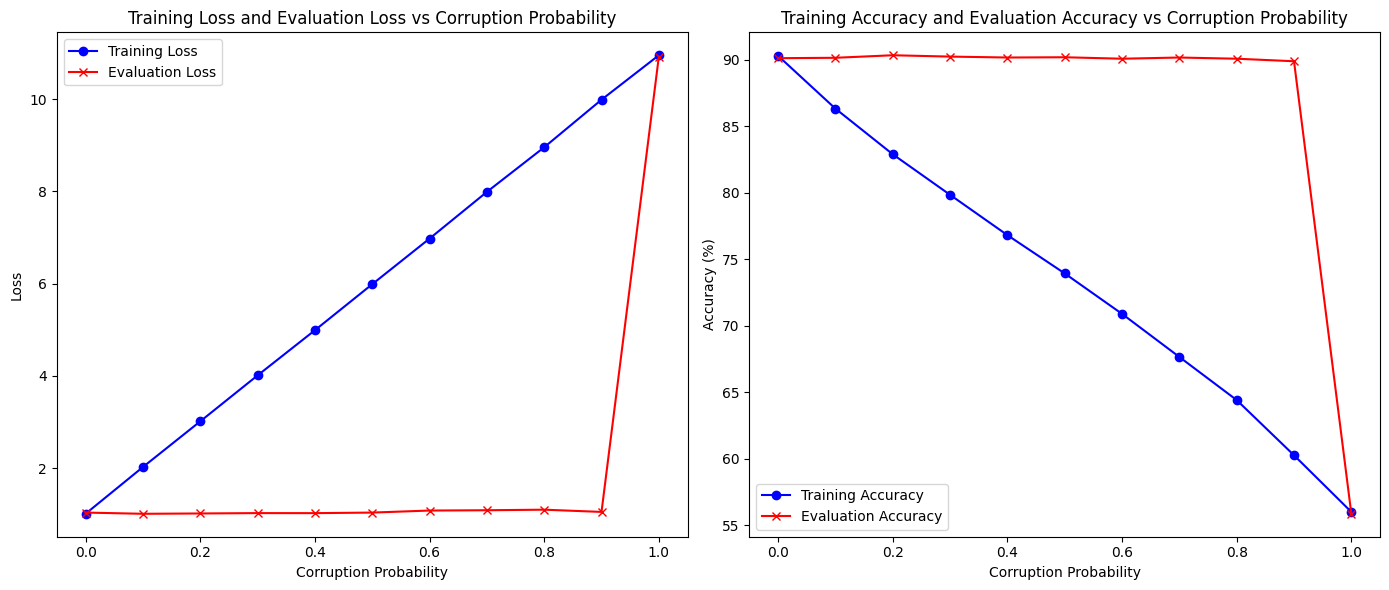

In [67]:
# Data for plotting (provided results)
corruption_probs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
training_losses = [1.0089, 2.0220, 3.0127, 4.0091, 4.9888, 5.9871, 6.9765, 7.9890, 8.9571, 9.9884, 10.9527]
training_accuracies = [90.29, 86.32, 82.89, 79.84, 76.81, 73.93, 70.89, 67.65, 64.41, 60.26, 56.00]
evaluation_losses = [1.0352, 1.0086, 1.0157, 1.0235, 1.0227, 1.0350, 1.0791, 1.0856, 1.0978, 1.0493, 10.9226]
evaluation_accuracies = [90.11, 90.14, 90.33, 90.23, 90.16, 90.18, 90.07, 90.16, 90.07, 89.88, 55.86]

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training loss and evaluation loss
ax1.plot(corruption_probs, training_losses, label='Training Loss', marker='o', color='b')
ax1.plot(corruption_probs, evaluation_losses, label='Evaluation Loss', marker='x', color='r')
ax1.set_xlabel('Corruption Probability')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Evaluation Loss vs Corruption Probability')
ax1.legend()

# Plot training accuracy and evaluation accuracy
ax2.plot(corruption_probs, training_accuracies, label='Training Accuracy', marker='o', color='b')
ax2.plot(corruption_probs, evaluation_accuracies, label='Evaluation Accuracy', marker='x', color='r')
ax2.set_xlabel('Corruption Probability')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy and Evaluation Accuracy vs Corruption Probability')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

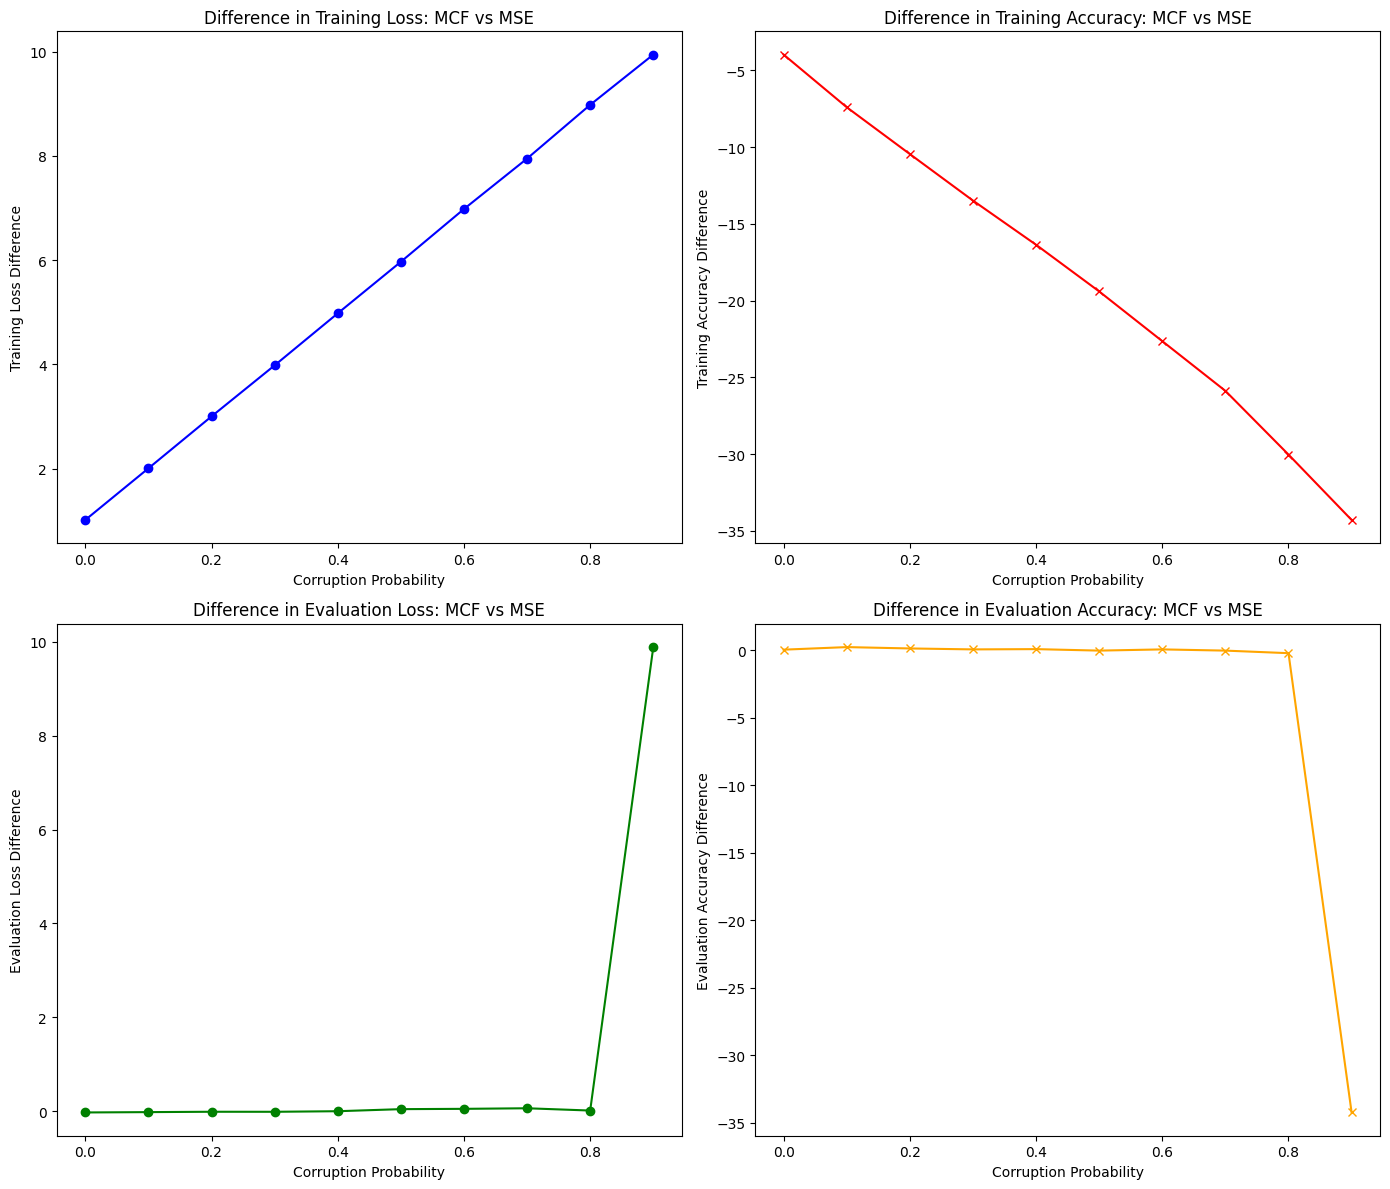

In [75]:
# Data for plotting (provided results for MSE and MCF)
corruption_probs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # 10 values for MCF
mse_training_losses = [1.0089] * len(corruption_probs)  # Same for all corruption probabilities
mse_training_accuracies = [90.29] * len(corruption_probs)  # Same for all corruption probabilities
mse_evaluation_losses = [1.0352] * len(corruption_probs)  # Same for all corruption probabilities
mse_evaluation_accuracies = [90.11] * len(corruption_probs)  # Same for all corruption probabilities

# MCF results (provided results for corruption probabilities)
mcf_training_losses = [2.0220, 3.0127, 4.0091, 4.9888, 5.9871, 6.9765, 7.9890, 8.9571, 9.9884, 10.9527]
mcf_training_accuracies = [86.32, 82.89, 79.84, 76.81, 73.93, 70.89, 67.65, 64.41, 60.26, 56.00]
mcf_evaluation_losses = [1.0086, 1.0157, 1.0235, 1.0227, 1.0350, 1.0791, 1.0856, 1.0978, 1.0493, 10.9226]
mcf_evaluation_accuracies = [90.14, 90.33, 90.23, 90.16, 90.18, 90.07, 90.16, 90.07, 89.88, 55.86]

# Calculate the differences between MCF and MSE for each corruption probability
loss_diff = [mcf_loss - mse_loss for mcf_loss, mse_loss in zip(mcf_training_losses, mse_training_losses)]
acc_diff = [mcf_acc - mse_acc for mcf_acc, mse_acc in zip(mcf_training_accuracies, mse_training_accuracies)]
eval_loss_diff = [mcf_loss - mse_loss for mcf_loss, mse_loss in zip(mcf_evaluation_losses, mse_evaluation_losses)]
eval_acc_diff = [mcf_acc - mse_acc for mcf_acc, mse_acc in zip(mcf_evaluation_accuracies, mse_evaluation_accuracies)]

# Create figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# Plot the difference in Training Loss
ax1.plot(corruption_probs, loss_diff, marker='o', color='b')
ax1.set_xlabel('Corruption Probability')
ax1.set_ylabel('Training Loss Difference')
ax1.set_title('Difference in Training Loss: MCF vs MSE')

# Plot the difference in Training Accuracy
ax2.plot(corruption_probs, acc_diff, marker='x', color='r')
ax2.set_xlabel('Corruption Probability')
ax2.set_ylabel('Training Accuracy Difference')
ax2.set_title('Difference in Training Accuracy: MCF vs MSE')

# Plot the difference in Evaluation Loss
ax3.plot(corruption_probs, eval_loss_diff, marker='o', color='g')
ax3.set_xlabel('Corruption Probability')
ax3.set_ylabel('Evaluation Loss Difference')
ax3.set_title('Difference in Evaluation Loss: MCF vs MSE')

# Plot the difference in Evaluation Accuracy
ax4.plot(corruption_probs, eval_acc_diff, marker='x', color='orange')
ax4.set_xlabel('Corruption Probability')
ax4.set_ylabel('Evaluation Accuracy Difference')
ax4.set_title('Difference in Evaluation Accuracy: MCF vs MSE')

# Show the plots
plt.tight_layout()
plt.show()

# **Gaussian Noise**

---



In [76]:
# Function to corrupt features dynamically with Gaussian noise
def corrupt_features_with_gaussian(x, mean=0.0, std=0.1):
    """
    Add Gaussian noise to the input features.

    Parameters:
    - x (Tensor): Input features of shape [batch_size, num_features].
    - mean (float): Mean of the Gaussian noise.
    - std (float): Standard deviation of the Gaussian noise.

    Returns:
    - Tensor: Corrupted features with Gaussian noise.
    """
    noise = torch.normal(mean=mean, std=std, size=x.size(), device=x.device)
    return x + noise  # Add the noise to the original features

In [77]:
# Quadratic loss for corrupted data
def quadratic_loss(model, inputs, targets, corruption_prob, criterion):
    # Corrupt the features dynamically with the given corruption probability
    corrupted_inputs = corrupt_features(inputs, corruption_prob)

    # Forward pass on the corrupted inputs
    outputs_corrupted = model(corrupted_inputs)

    # Compute the loss (using quadratic loss, assuming it's based on corrupted data)
    loss = criterion(outputs_corrupted, targets)

    return loss, outputs_corrupted  # Return both loss and outputs for accuracy calculation

In [78]:
# MSE loss for uncorrupted data
def mse_loss(model, inputs, targets, criterion):
    # Forward pass on the uncorrupted inputs
    outputs = model(inputs)

    # Compute MSE loss
    loss = criterion(outputs, targets)

    return loss

In [79]:
# Train the model with MCF (quadratic loss on corrupted data)
def train_model_with_mcf(model, train_loader, test_loader, criterion, optimizer, corruption_prob, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            # Compute the loss using corrupted data (quadratic loss)
            loss, outputs_corrupted = quadratic_loss(model, inputs, targets, corruption_prob, criterion)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs_corrupted > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

        # Training accuracy
        train_accuracy = total_correct / total_samples * 100
        print(f"Training Loss: {total_loss/len(train_loader):.4f} | Training Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model
        evaluate_model(model, test_loader, criterion)

In [80]:
# Train the model with MSE Loss on uncorrupted data
def train_model_with_mse(model, train_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            # Compute the loss using uncorrupted data (MSE loss)
            loss = mse_loss(model, inputs, targets, criterion)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            # Compute the outputs for accuracy calculation
            outputs = model(inputs)

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

        # Training accuracy
        train_accuracy = total_correct / total_samples * 100
        print(f"Training Loss: {total_loss/len(train_loader):.4f} | Training Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model
        evaluate_model(model, test_loader, criterion)

In [81]:
# Evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Track metrics
            total_loss += loss.item()
            total_correct += ((outputs > 0.5) == (targets > 0.5)).sum().item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples * 100
    print(f"Evaluation Loss: {total_loss/len(data_loader):.4f} | Evaluation Accuracy: {accuracy:.2f}%")

In [91]:
# Main script
if __name__ == "__main__":
    # Dataset parameters
    num_features = 10
    corruption_prob = 1
    batch_size = 32
    epochs = 10
    learning_rate = 0.01

    # Generate datasets
    def generate_fake_dataset(num_samples, num_features, random_seed=42):
        torch.manual_seed(random_seed)
        data = torch.randn(num_samples, num_features)
        labels = torch.sum(data, dim=1, keepdim=True) + torch.randn(num_samples, 1)  # Add noise
        return data, labels

    # Generate the fake dataset
    train_features, train_labels = generate_fake_dataset(90000, num_features)
    test_features, test_labels = generate_fake_dataset(20000, num_features)
    eval_features, eval_labels = generate_fake_dataset(10000, num_features)

    # Create DataLoaders
    train_loader = DataLoader(TensorDataset(train_features, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_features, test_labels), batch_size=batch_size, shuffle=False)
    eval_loader = DataLoader(TensorDataset(eval_features, eval_labels), batch_size=batch_size, shuffle=False)

    # Initialize model, loss, and optimizer
    model = MCFNet(input_dim=num_features, hidden_dim=20, output_dim=1)
    criterion = nn.MSELoss()  # MSE loss for training on uncorrupted data
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save the dataset to a file (for later use)
    torch.save({
        'train_features': train_features,
        'train_labels': train_labels,
        'test_features': test_features,
        'test_labels': test_labels,
        'eval_features': eval_features,
        'eval_labels': eval_labels
    }, 'fake_dataset.pth')
    print("Dataset saved to 'fake_dataset.pth'")

    # Step 1: Train the model with MCF (using corrupted data and Quadratic Loss)
    print("Training with MCF (Quadratic Loss on corrupted data):")
    train_model_with_mcf(model, train_loader, eval_loader, criterion, optimizer, corruption_prob, epochs)

    # Reinitialize the model for training without MCF (using original, uncorrupted data)
    model = MCFNet(input_dim=num_features, hidden_dim=20, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Step 2: Train the model with MSE Loss on uncorrupted data
    print("\nTraining without MCF (using MSE on original data):")
    train_model_with_mse(model, train_loader, test_loader, criterion, optimizer, epochs)

Dataset saved to 'fake_dataset.pth'
Training with MCF (Quadratic Loss on corrupted data):
Training Loss: 10.9556 | Training Accuracy: 56.00%
Evaluation Loss: 10.9132 | Evaluation Accuracy: 55.86%
Training Loss: 10.9531 | Training Accuracy: 56.00%
Evaluation Loss: 10.9179 | Evaluation Accuracy: 55.86%
Training Loss: 10.9544 | Training Accuracy: 56.00%
Evaluation Loss: 10.9125 | Evaluation Accuracy: 55.86%
Training Loss: 10.9543 | Training Accuracy: 56.00%
Evaluation Loss: 10.9132 | Evaluation Accuracy: 55.86%
Training Loss: 10.9541 | Training Accuracy: 56.00%
Evaluation Loss: 10.9182 | Evaluation Accuracy: 55.86%
Training Loss: 10.9532 | Training Accuracy: 56.00%
Evaluation Loss: 10.9131 | Evaluation Accuracy: 55.86%
Training Loss: 10.9532 | Training Accuracy: 56.00%
Evaluation Loss: 10.9208 | Evaluation Accuracy: 55.86%
Training Loss: 10.9528 | Training Accuracy: 56.00%
Evaluation Loss: 10.9124 | Evaluation Accuracy: 55.86%
Training Loss: 10.9564 | Training Accuracy: 56.00%
Evaluation 

Training without MCF (using MSE on original data):

Training Loss: 1.0089 | Training Accuracy: 90.29%
Evaluation Loss: 1.0352 | Evaluation Accuracy: 90.11%

Training with MCF (Quadratic Loss on corrupted data):

0.1:
Training Loss: 2.0220 | Training Accuracy: 86.32%
Evaluation Loss: 1.0086 | Evaluation Accuracy: 90.14%

0.2:
Training Loss: 3.0127 | Training Accuracy: 82.89%
Evaluation Loss: 1.0157 | Evaluation Accuracy: 90.33%

0.3:
Training Loss: 4.0091 | Training Accuracy: 79.84%
Evaluation Loss: 1.0235 | Evaluation Accuracy: 90.23%

0.4:
Training Loss: 4.9888 | Training Accuracy: 76.81%
Evaluation Loss: 1.0227 | Evaluation Accuracy: 90.16%

0.5:
Training Loss: 5.9871 | Training Accuracy: 73.93%
Evaluation Loss: 1.0350 | Evaluation Accuracy: 90.18%

0.6:
Training Loss: 6.9765 | Training Accuracy: 70.89%
Evaluation Loss: 1.0791 | Evaluation Accuracy: 90.07%

0.7:
Training Loss: 7.9890 | Training Accuracy: 67.65%
Evaluation Loss: 1.0856 | Evaluation Accuracy: 90.16%

0.8:
Training Loss: 8.9571 | Training Accuracy: 64.41%
Evaluation Loss: 1.0978 | Evaluation Accuracy: 90.07%

0.9:
Training Loss: 9.9884 | Training Accuracy: 60.26%
Evaluation Loss: 1.0493 | Evaluation Accuracy: 89.88%

1:
Training Loss: 10.9527 | Training Accuracy: 56.00%
Evaluation Loss: 10.9226 | Evaluation Accuracy: 55.86%

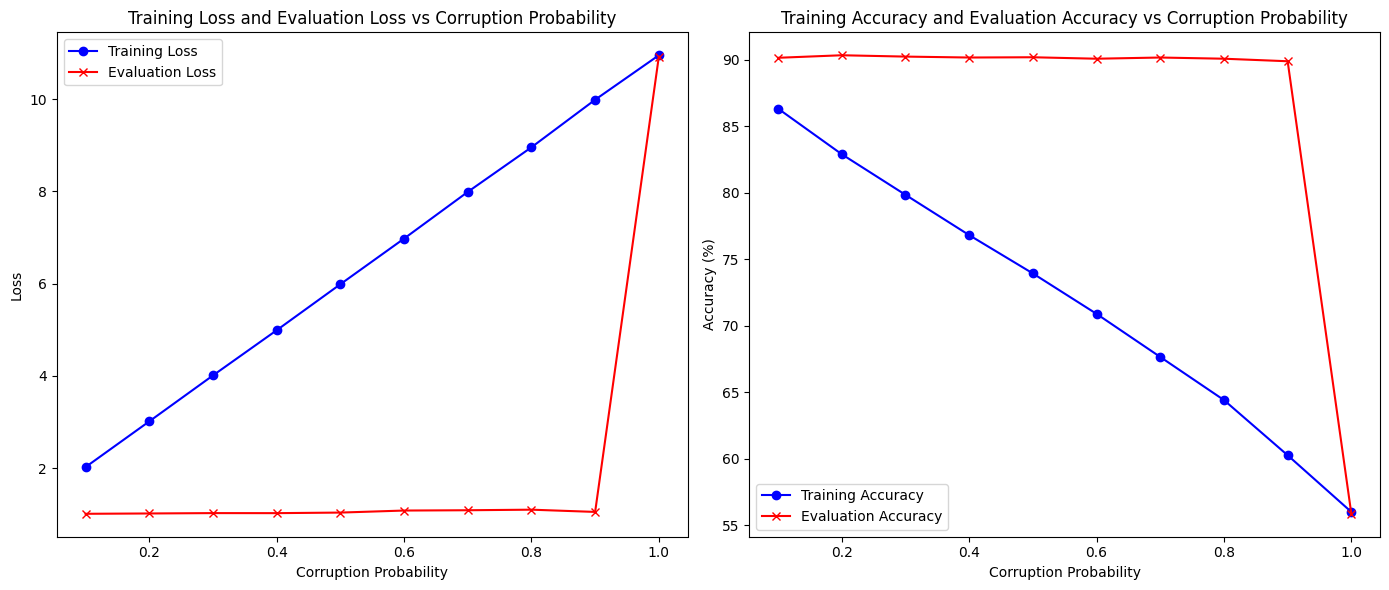

In [96]:
# Data for plotting (provided results for MCF)
corruption_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # 10 values for MCF
mcf_training_losses = [2.0220, 3.0127, 4.0091, 4.9888, 5.9871, 6.9765, 7.9890, 8.9571, 9.9884, 10.9527]
mcf_training_accuracies = [86.32, 82.89, 79.84, 76.81, 73.93, 70.89, 67.65, 64.41, 60.26, 56.00]
mcf_evaluation_losses = [1.0086, 1.0157, 1.0235, 1.0227, 1.0350, 1.0791, 1.0856, 1.0978, 1.0493, 10.9226]
mcf_evaluation_accuracies = [90.14, 90.33, 90.23, 90.16, 90.18, 90.07, 90.16, 90.07, 89.88, 55.86]

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training loss and evaluation loss
ax1.plot(corruption_probs, mcf_training_losses, label='Training Loss', marker='o', color='b')
ax1.plot(corruption_probs, mcf_evaluation_losses, label='Evaluation Loss', marker='x', color='r')
ax1.set_xlabel('Corruption Probability')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Evaluation Loss vs Corruption Probability')
ax1.legend()

# Plot training accuracy and evaluation accuracy
ax2.plot(corruption_probs, mcf_training_accuracies, label='Training Accuracy', marker='o', color='b')
ax2.plot(corruption_probs, mcf_evaluation_accuracies, label='Evaluation Accuracy', marker='x', color='r')
ax2.set_xlabel('Corruption Probability')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy and Evaluation Accuracy vs Corruption Probability')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

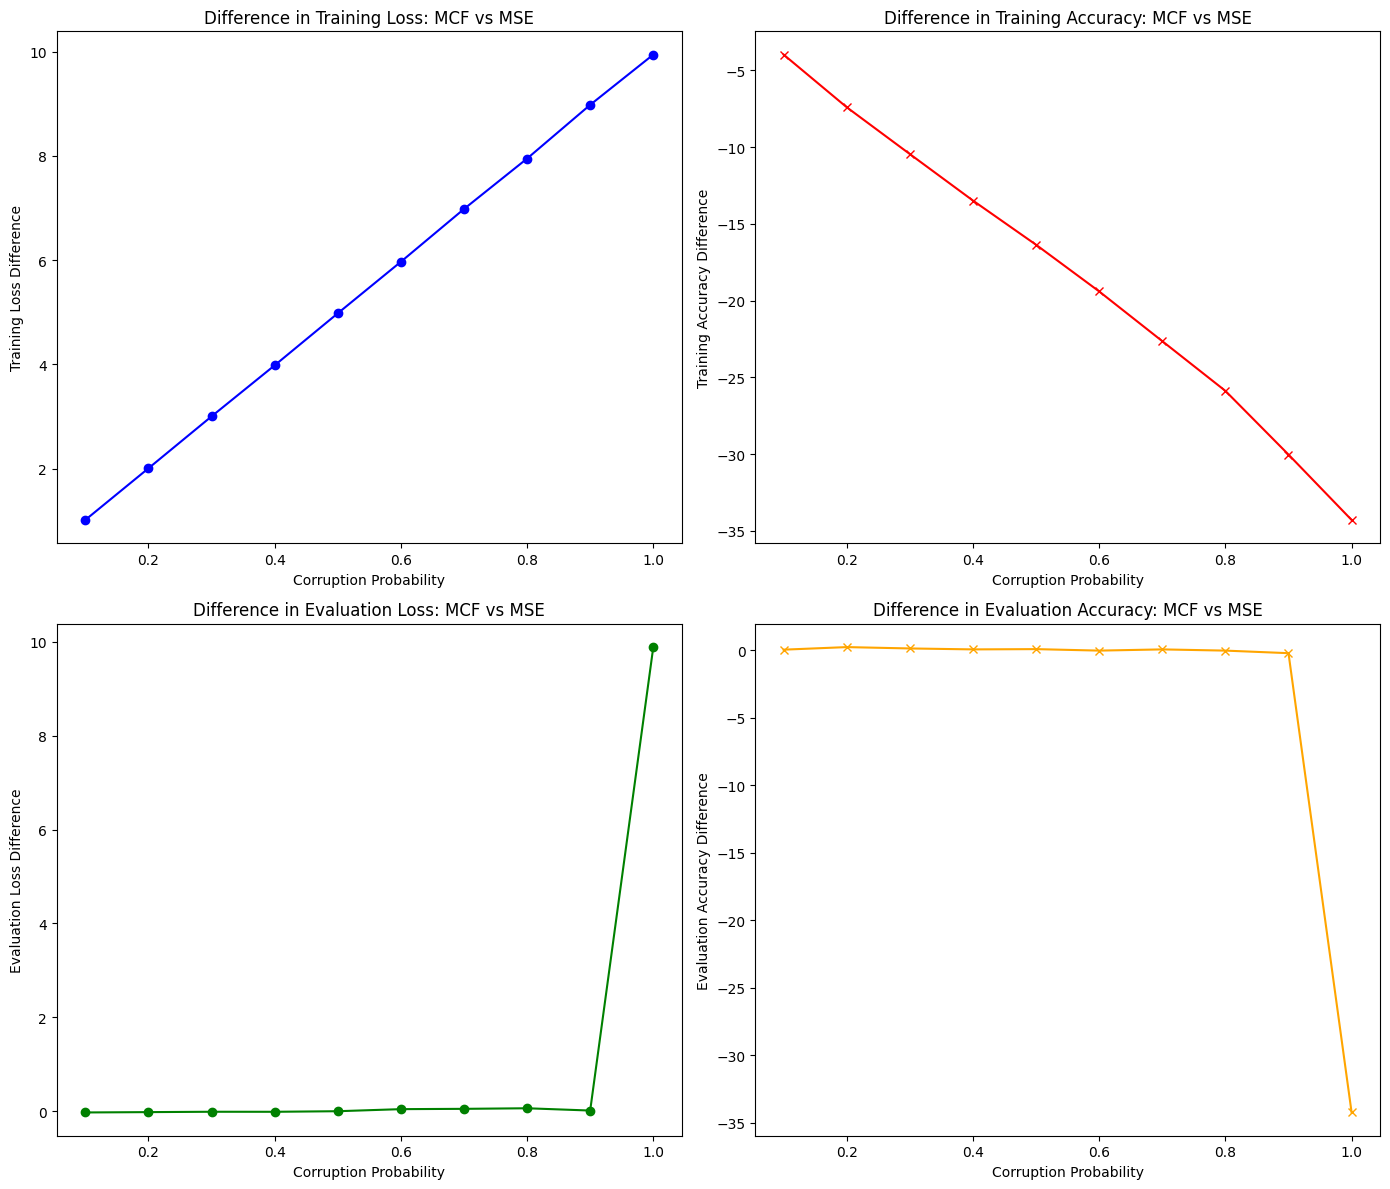

In [93]:
# Data for plotting (provided results for MSE and MCF)
corruption_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # 10 values for MCF
mse_training_losses = [1.0089] * len(corruption_probs)  # Same for all corruption probabilities
mse_training_accuracies = [90.29] * len(corruption_probs)  # Same for all corruption probabilities
mse_evaluation_losses = [1.0352] * len(corruption_probs)  # Same for all corruption probabilities
mse_evaluation_accuracies = [90.11] * len(corruption_probs)  # Same for all corruption probabilities

# MCF results (provided results for corruption probabilities)
mcf_training_losses = [2.0220, 3.0127, 4.0091, 4.9888, 5.9871, 6.9765, 7.9890, 8.9571, 9.9884, 10.9527]
mcf_training_accuracies = [86.32, 82.89, 79.84, 76.81, 73.93, 70.89, 67.65, 64.41, 60.26, 56.00]
mcf_evaluation_losses = [1.0086, 1.0157, 1.0235, 1.0227, 1.0350, 1.0791, 1.0856, 1.0978, 1.0493, 10.9226]
mcf_evaluation_accuracies = [90.14, 90.33, 90.23, 90.16, 90.18, 90.07, 90.16, 90.07, 89.88, 55.86]

# Calculate the differences between MCF and MSE for each corruption probability
loss_diff = [mcf_loss - mse_loss for mcf_loss, mse_loss in zip(mcf_training_losses, mse_training_losses)]
acc_diff = [mcf_acc - mse_acc for mcf_acc, mse_acc in zip(mcf_training_accuracies, mse_training_accuracies)]
eval_loss_diff = [mcf_loss - mse_loss for mcf_loss, mse_loss in zip(mcf_evaluation_losses, mse_evaluation_losses)]
eval_acc_diff = [mcf_acc - mse_acc for mcf_acc, mse_acc in zip(mcf_evaluation_accuracies, mse_evaluation_accuracies)]

# Create figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# Plot the difference in Training Loss
ax1.plot(corruption_probs, loss_diff, marker='o', color='b')
ax1.set_xlabel('Corruption Probability')
ax1.set_ylabel('Training Loss Difference')
ax1.set_title('Difference in Training Loss: MCF vs MSE')

# Plot the difference in Training Accuracy
ax2.plot(corruption_probs, acc_diff, marker='x', color='r')
ax2.set_xlabel('Corruption Probability')
ax2.set_ylabel('Training Accuracy Difference')
ax2.set_title('Difference in Training Accuracy: MCF vs MSE')

# Plot the difference in Evaluation Loss
ax3.plot(corruption_probs, eval_loss_diff, marker='o', color='g')
ax3.set_xlabel('Corruption Probability')
ax3.set_ylabel('Evaluation Loss Difference')
ax3.set_title('Difference in Evaluation Loss: MCF vs MSE')

# Plot the difference in Evaluation Accuracy
ax4.plot(corruption_probs, eval_acc_diff, marker='x', color='orange')
ax4.set_xlabel('Corruption Probability')
ax4.set_ylabel('Evaluation Accuracy Difference')
ax4.set_title('Difference in Evaluation Accuracy: MCF vs MSE')

# Show the plots
plt.tight_layout()
plt.show()